In [1]:
#text in code cells
from IPython.display import Markdown as md
# multidimensional arrays
import numpy as np
# inline plots
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
# nicer figures
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Return to the origin


For a *finite* random walk of (large) length $n$, it is known that the expected number of returns to the origin $T_n$ scales like follows:
$$
\left\langle T_n \right\rangle \sim \left\{
\begin{array}{ll}
\sqrt{n} & d=1 \\
\log(n) & d=2 \\
C_d & d\geq 3
\end{array}
\right.
$$


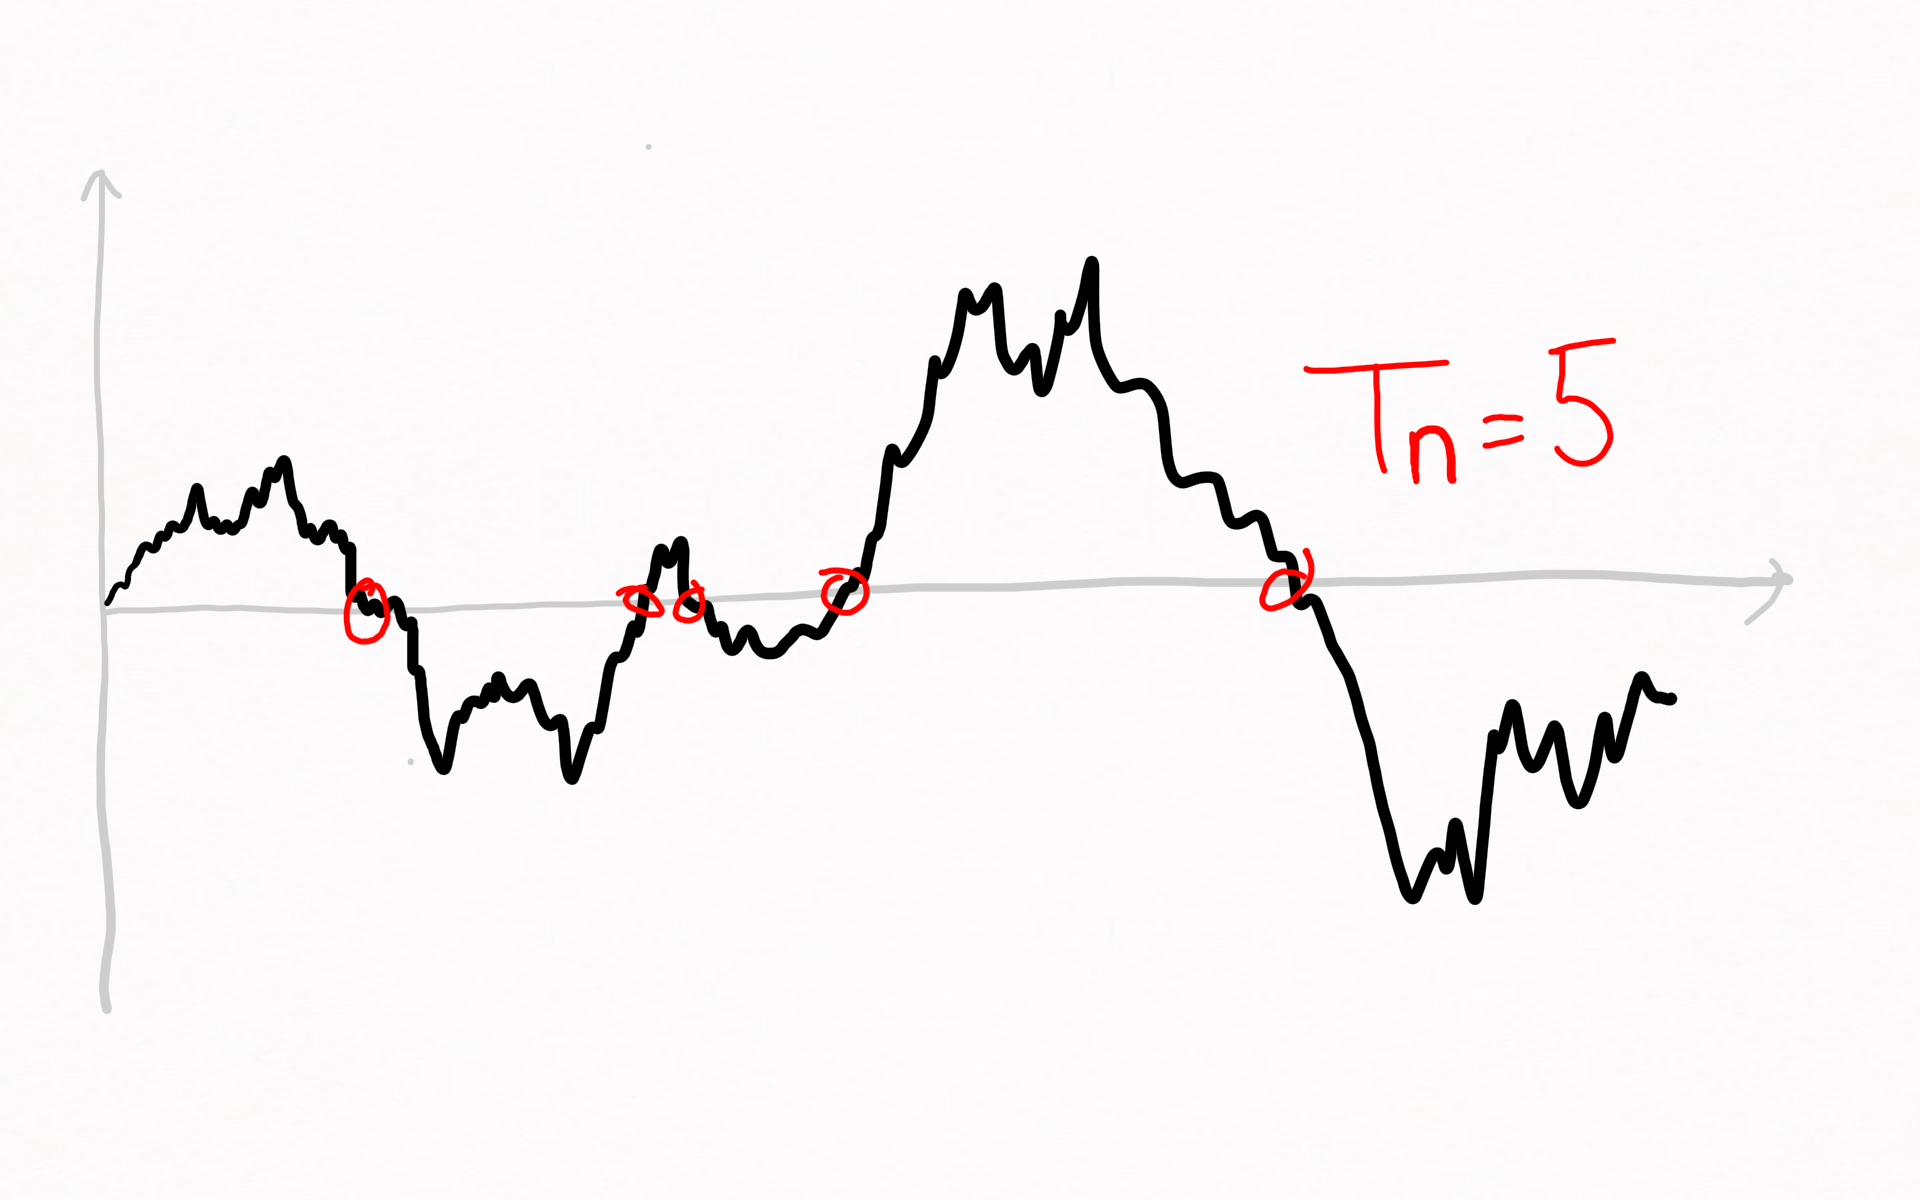

Notice that for $d \geq 3$, $\left\langle T_n \right\rangle$ does **not** grow with $n$, which must mean that the walker somehow "escapes" and never returns back to the origin. The probability of return to the origin is less than 1! For an infinite-length random walk, indeed the probability of returning to the origin $\rho$ is seen to be

$$
\rho \sim \left\{
\begin{array}{ll}
1 & d=1 \\
1 & d=2 \\
<1 & d\geq 3
\end{array}
\right.
$$

The *intuitive* explanation of this amazing fact is that, as the dimension $d$ grows, there are "more directions available", and so more chances for the walker to "get lost" and never return to the origin. There is of course a formal proof as well, but today we will do a **computational verification** of these facts, which is no substitute for a formal proof but is often all we can do!

## Generating Random Walks


### Exercise 3.1
Write a function that generates a random walk of given length in $d$ dimensions. Your random walker should move as follows:

+ At each time-step, the walker moves only in one direction.
+ At each time-step, the walker moves only by -1 or +1

Your function should return a numpy array of shape (`length`, `dim`). Example:
```python
>>> # create a RW of length 10 in dimension 3
>>> traj = get_traj(length=10, dim=3)
>>> # check that the output has the right shape
>>> traj.shape
(10, 3)
```

In [2]:
"""Generate a RW in d dimensions
    
    Parameters
    ----------
    length: int
        Length of the RW.
    dim: int
        Dimension of the RW


    Returns
    -------
    traj : np.ndarray, (length, dim)
        The positions of the RW.
    
    Notes
    -----
    At each time-step, the walker moves in only one direction.
    At each time-step, the walker moves by -1 or +1
"""
    
def get_traj(length: int, dim: int):
    
    traj=np.zeros((length,dim)) 
    dir_array=np.random.randint(dim,size=length) #this choose in which direction to move
    updown_array=np.random.uniform(0, 1, size=length) #this choose if going "up" or "down" in that direction
    
    for i in range(1, length): #It starts from 1 because we want the starting point to be the origin vec(0).
        direc=dir_array[i]
        updown=updown_array[i]
        traj[i,:]=traj[i-1,:]
        if updown < 0.5:
            traj[i,direc]+=1
        else:
            traj[i,direc]-=1
    return traj

### Verification
To make sure that your function works correctly, execute the following cell. Notice the use of `assert` statements: execution should fail if something goes wrong. If everything is fine, nothing should happen.

In [3]:
# basic checks for your RW generator
for dim in range(1, 5):
    for length in [10, 100, 200, 500]:
        traj = get_traj(length=length, dim=dim)
        # make sure traj has the right shape
        assert traj.shape == (length, dim)
        # make sure all steps are -1 or 1 in only one direction
        assert np.all(np.sum(np.diff(traj, axis=0) != 0, axis=1) == np.ones(length - 1))

### Exercise 3.2
Plot a random walk of length $10^4$ for $d=1$ (time in x-axis, position in y-axis) and $d=2$ (x,y components in x,y-axis). Remember to use **axis labels**.

In [4]:
# it is better if you use one cell to generate the random walks, and a second cell to plot them
length = 10**4
RW_1d = get_traj(length,1)
RW_2d = get_traj(length,2)

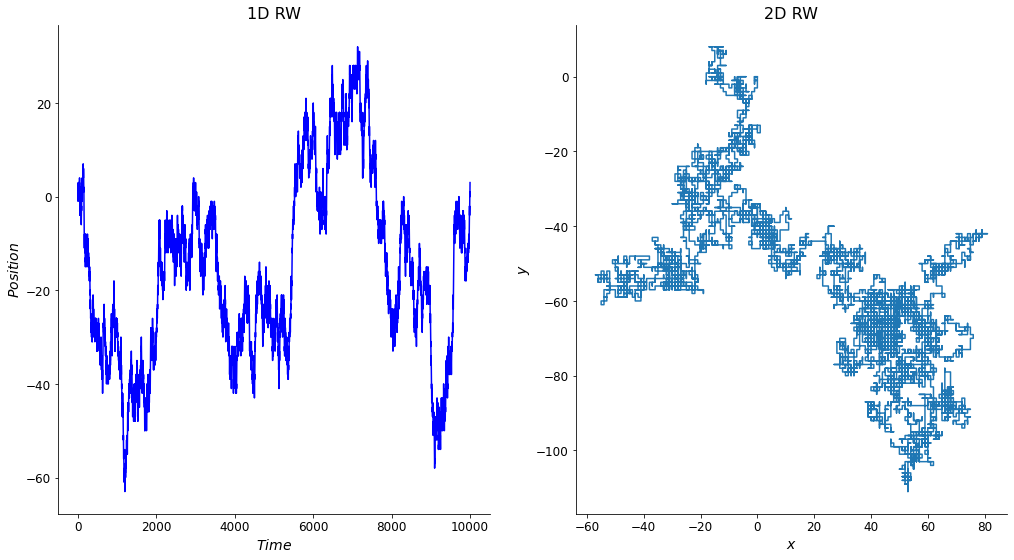

In [5]:
# We generate a figure with two subplots, called axis in matplotlib.
#
# To use the left subplot, we do
# ax1.plot(...)
#
# while to use the right subplot, we do
# ax2.plot(..)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 9))
t=np.linspace(0,length,length)
ax1.plot(t, RW_1d,color="blue")
ax1.set_xlabel(r"$Time$")
ax1.set_ylabel(r"$Position$")
ax1.set_title(r"1D RW");

ax2.plot(RW_2d[:,0], RW_2d[:,1])
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")
ax2.set_title(r"2D RW");

## Counting the number of returns to the origin
Since we are interested in how **the expected number of returns to the origin** scales with the RW length, we don't need to store the whole trajectory of each simulation (we will be performing many simulations!). 

### Exercise 3.3
Write a function that generates a RW of given length and dimension (calling `get_traj`), and returns the number of times it returned to the origin. To count the number of returns to the origin, you might need to use the following functions:
```python
np.all()
np.zeros()
```

In [6]:
def get_num_returns(length, dim):
    # generate a RW of given length and dimension
    traj = get_traj(length,dim)
    num_returns_to_origin = 0
    # count how many times it goes through the origin
    for i in range(1, length):
        if np.array_equiv(traj[i,:],np.zeros(dim)): #this checks if the position is equal to the origin
            num_returns_to_origin += 1
    return num_returns_to_origin

### Exercise 3.4
Write a function that computes the expected number of returns to the origin for a given length and dimension. Your function will call `get_num_returns()`, and should have an additional parameter that sets the sample size.

In [7]:
def get_average_num_returns(length, dim, num_trajs=200):
    average_num_returns = 0
    for i in range(num_trajs):
        average_num_returns = average_num_returns + get_num_returns(length,dim)
    average_num_returns = average_num_returns / num_trajs
    return average_num_returns

## Comparing with analytical results
We are now ready to compare our analytical results with numerical simulations! We want to plot the expected number of returns to the origin as a function of the RW length. To do this, it is useful to first define an array of RW lengths.

In [8]:
# define range of RW lengths
length_min = 10
length_max = 100000
# generate points logarithmically spaces
# and convert them to integers
length_array = np.array([
    int(x)
    for x in np.geomspace(length_min, length_max, num=25)
])

(tip: if your RW generating function is not very efficient, you might want to decrease `length_min`)  

Executing the following cell will run all simulations for $d=1$


In [9]:
dim=1
num_d1_returns_array = np.array([
    get_average_num_returns(length=length, dim=dim, num_trajs=5000)
    for length in length_array
])

### Exercise 3.5
Plot the average number of returns to the origin of a 1D RW as a function of the RW length, together with the expected theoretical result. Do your results verify the $n^{1/2}$ scaling? **Tip** Use double-logarithmic scales in your plot. Remember to include label axis, and a legend!

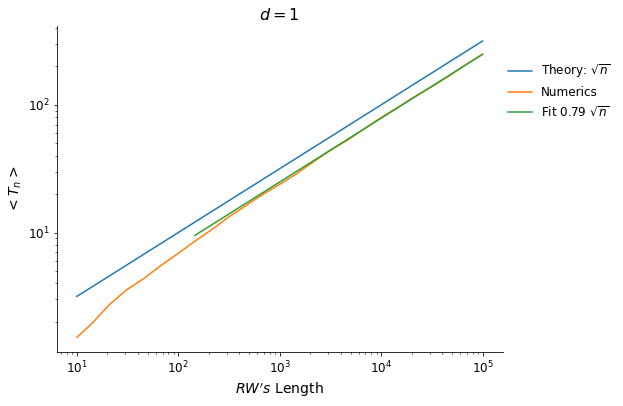

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# plot theoretical result
root_length_array=np.sqrt(length_array)
ax.loglog(length_array, root_length_array, label="Theory: $\sqrt{n}$")
# plot numerical result
ax.loglog(length_array, num_d1_returns_array,label="Numerics")

# plot theoretical fit
start1=7 # we neglet the first points in the fit because we want the trend in the limit of large n
length_array_Fit1=length_array[start1:]
num_d1_returns_array_Fit=num_d1_returns_array[start1:]

fsqrt = lambda length_array_Fit1, k1: k1 * np.sqrt(length_array_Fit1) # sqrt fit
popt, _ = curve_fit(fsqrt, length_array_Fit1, num_d1_returns_array_Fit)
k1 = popt[0]
ktrunc1 = "%.2f" % k1
ax.loglog(length_array_Fit1, k1 * np.sqrt(length_array_Fit1), label="Fit " + str(ktrunc1) +  " $\sqrt{n}$")

# add axis labels
ax.set_xlabel(r"$RW's $" r" Length")
ax.set_ylabel(r"$<T_n>$")
# add a legend
ax.legend(loc=(1, 0.7), frameon=False)
# add a title (e.g. that says what dimension we used)
ax.set_title(r"$d=1$");

#### Conclusions
The simulation of the average number of returns to the origin, for a Random Walk in 1 dimension, as a function of the Random Walk length $n$, is compatible with a $\sqrt{n}$ scaling (for large n)!

In [34]:
md("More precisely it is compatible with a {} * $\sqrt n$ scaling.".format(ktrunc1))

More precisely it is compatible with a 0.79 * $\sqrt n$ scaling.

### Exercise 3.6
Plot the average number of returns to the origin of a 2D RW as a function of the RW length. Do your results verify the $log(n)$ scaling? What are the best axis scales to use in this case?

In [12]:
# do the simulations for d=2
dim=2
num_d2_returns_array = np.array([
    get_average_num_returns(length=length, dim=dim, num_trajs=5000)
    for length in length_array
])

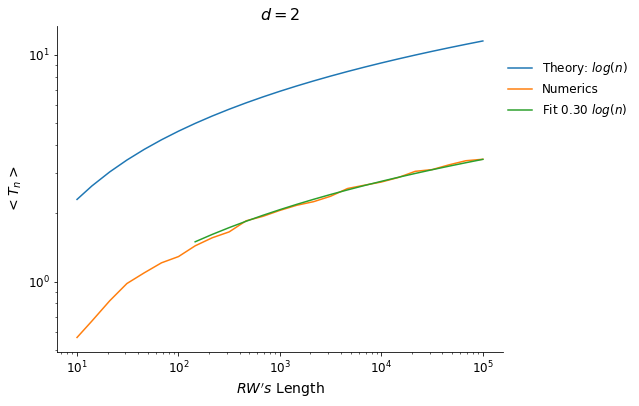

In [43]:
# plot the numerical results + theory
fig, axx = plt.subplots(1, 1, figsize=(8, 6))
# plot theoretical result
log_length_array=np.log(length_array)
axx.loglog(length_array, log_length_array, label="Theory: $log(n)$")
# plot numerical result
axx.loglog(length_array, num_d2_returns_array,label="Numerics")

# plot theoretical fit
start2=7
length_array_Fit2=length_array[start2:]
num_d2_returns_array_Fit=num_d2_returns_array[start2:]
flog = lambda length_array_Fit2, k2: k2 * np.log(length_array_Fit2) # log fit
popt, _ = curve_fit(flog, length_array_Fit2, num_d2_returns_array_Fit)
k2 = popt[0]
ktrunc2 = "%.2f" % k2
axx.loglog(length_array_Fit2, k2 * np.log(length_array_Fit2), label="Fit " + str(ktrunc2) +  " $log(n)$")

# add axis labels
axx.set_xlabel(r"$RW's $" r" Length")
axx.set_ylabel(r"$<T_n>$")
# add a legend
axx.legend(loc=(1, 0.7), frameon=False)
# add a title (e.g. that says what dimension we used)
axx.set_title(r"$d=2$");

#### Conclusions
The simulation of the average number of returns to the origin, for a Random Walk in 2 dimensions, as a function of the Random Walk length $n$, is compatible with a $log(n)$ scaling (for large n)! 

In [35]:
md("More precisely it is compatible with a {} * $log(n)$ scaling.".format(ktrunc2))

More precisely it is compatible with a 0.30 * $log(n)$ scaling.

## Exercise 3.7
Show numerically that, for $d=3$ and $d=4$, the expected number of returns to the origin is **constant**.

In [15]:
# your numerical answer here
# you can use more than one cell of course!
# use markdown cells and code cells if necessary

In [16]:
dim=3
num_d3_returns_array = np.array([
    get_average_num_returns(length=length, dim=dim, num_trajs=5000)
    for length in length_array
])

In [17]:
dim=4
num_d4_returns_array = np.array([
    get_average_num_returns(length=length, dim=dim, num_trajs=5000)
    for length in length_array
])

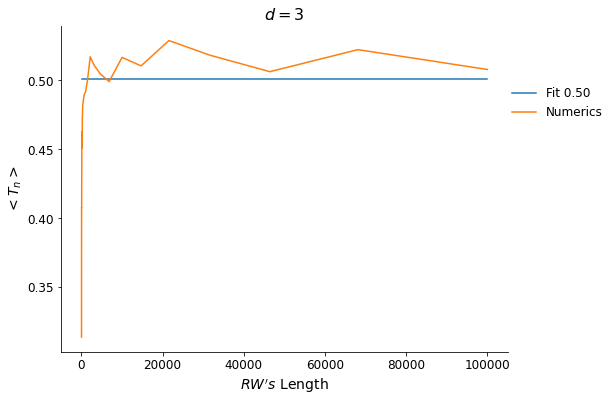

In [44]:
# d=3
fig, axxx = plt.subplots(1, 1, figsize=(8, 6))

#Fit
start3=7
length_array_Fit3=length_array[start3:]
num_d3_returns_array_Fit=num_d3_returns_array[start3:]
fcost3 = lambda length_array_Fit3, k3: k3 * np.ones(len(length_array_Fit3)) # const fit
popt, _ = curve_fit(fcost3, length_array_Fit3, num_d3_returns_array_Fit)
k3 = popt[0]
ktrunc3 = "%.2f" % k3
axxx.plot(length_array_Fit3, k3 * np.ones(len(length_array_Fit3)), label="Fit " + str(ktrunc3))

# plot numerical result
axxx.plot(length_array, num_d3_returns_array,label="Numerics")
# add axis labels
axxx.set_xlabel(r"$RW's $" r" Length")
axxx.set_ylabel(r"$<T_n>$")
# add a legend
axxx.legend(loc=(1, 0.7), frameon=False)
# add a title (e.g. that says what dimension we used)
axxx.set_title(r"$d=3$");

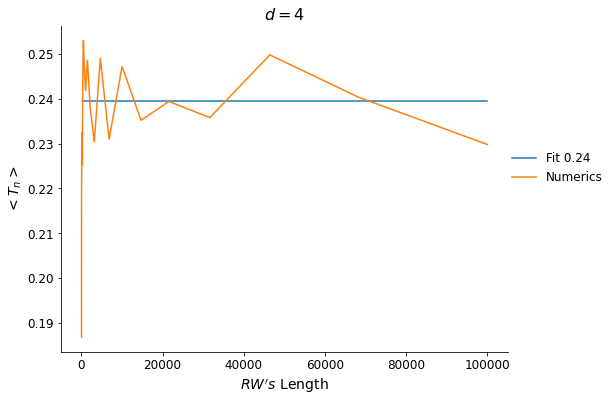

In [45]:
# d=4
fig, axxxx = plt.subplots(1, 1, figsize=(8, 6))
#Fit
start4=7
length_array_Fit4=length_array[start4:]
num_d4_returns_array_Fit=num_d4_returns_array[start4:]
fcost4 = lambda length_array_Fit4, k4: k4 * np.ones(len(length_array_Fit4)) # const fit
popt, _ = curve_fit(fcost4, length_array_Fit4, num_d4_returns_array_Fit)
k4 = popt[0]
ktrunc4 = "%.2f" % k4
axxxx.plot(length_array_Fit4, k4 * np.ones(len(length_array_Fit4)), label="Fit " + str(ktrunc4))

# plot numerical result
axxxx.plot(length_array, num_d4_returns_array,label="Numerics")
# add axis labels
axxxx.set_xlabel(r"$RW's $" r" Length")
axxxx.set_ylabel(r"$<T_n>$")
# add a legend
axxxx.legend(loc=(1, 0.5), frameon=False)
# add a title (e.g. that says what dimension we used)
axxxx.set_title(r"$d=4$");

#### Conclusions

In [36]:
md("From these graph we can conclude that the expected number of returns to the origin for $dim=3$ and $dim=4$ is a costant, that is respectively equal to {} ($d=3$) and  {} ($d=4$).".format(ktrunc3, ktrunc4))

From these graph we can conclude that the expected number of returns to the origin for $dim=3$ and $dim=4$ is a costant, that is respectively equal to 0.50 ($d=3$) and  0.24 ($d=4$).

## N.B.:

In all graphs and calculations I have considered the number of **returns** to the origin, this means that the starting point is not counted, if we want the number of **visits** (i.e. with the starting point included) we should then add 1 to the results.

# Self-Avoiding Walks
Self-avoiding walks (SAW) are simply random walks in a regular lattice with the additional constraint that no point can be visited more than once. That is, SAWs cannot intersect themselves. The most well-known application of SAW is to model linear polymers, where obviously two monomers cannot occupy the same space (excluded volume effect).


You can read more about self-avoiding walks in this nice introduction by Gordon Slade:

[Self-Avoiding Walks, by Gordon Slade](https://www.math.ubc.ca/~slade/intelligencer.pdf)

## Simulating Self-Avoiding Walks
Generating a SAW is not trivial. If you try to generate a SAW stochastically, that is, one step at a time, you will miserably fail: your walker might get into traps (configurations with no allowed movements), and if it does you will have to discard your simulation. It turns out you will have to discard your simulation *really* often, so that for large lengths, you will basically never find a valid path. In addition, the paths you will find for short lengths will not come up with the right probabilities. Bear in mind that we want to **uniformly sample** the set of SAW of given length $n$, SAW($n$). That is, we want that all paths from SAW($n$) are generated with the same probability.

The solution is to use a Monte Carlo algorithm that, given one element $\alpha \in \text{SAW}(n)$, generates a new one $\beta \in \text{SAW}(n)$ with some probability $P_{\alpha \beta}$. If in addition our algorithm satisfies **detailed balance** and is **ergodic**, then we known that it will converge to the equilibrium distribution (the uniform distribution in our case).


## The pivot algorithm
We will implement the pivot algorithm, which is simple, effective, and satisfies detailed balance and ergodicity. You can read about the details of the pivot algorithm here:

[The Pivot Algorithm: A Highly Efficient Monte Carlo Method for the Self-Avoiding Walk](https://link.springer.com/article/10.1007/BF01022990)

(tip: if you're at home, **do not** use tools such as sci-hub to download the paper).

Given a self-avoiding walk of length $n$, the pivot algorithm generates the next walk $\beta \in \text{SAW}(n)$ as follows:

1. **Choose a point of $\alpha$ at random**, splitting the path in two bits: the head (from the origin to the chosen point) and the tail (from the chosen point to the end of the path). Notice that both the head and the tail are SAWs.
2. **Apply a transformation to the tail**, leaving the head intact. The transformation must be an orthoganl transformation that leaves the regular lattice intact (so, either a reflection or a $90º, 180º$ or $270º$ rotation). For simplicity, we will use only **rotations** (read the paper to see why this is ok).
3. **Check if the new path is self-avoiding**. If so, return it. Otherwise, return the original path.

Iterating these steps one obtains a **Markov** chain of SAWs: $\alpha_1 \to \alpha_2 \to \dots \to \alpha_M $. Notice that $\alpha_i$ are not uncorrelated, but because the algorithm satisfies detailed balance and is ergodic, we know that it approaches the equilibrium distribution. This means that we can use our Markov chain to compute **expected values** as long as it is long enough.

## Implementing the pivot step in 2D
To implement the **pivot algorithm** in 2D, we will write one function that does steps 1 and 2, and another function that does step 3. We will also need a function to generate standard 2D random walks.

### Exercise 3.8
Write a function `get_traj` that generates a 2D random walk of given length.

In [21]:
def get_traj2(length):
#    """Generate a 2D random walk of given length"""  
    traj2=np.zeros((length,2))
    dir_array=np.random.randint(2,size=length)
    updown_array=np.random.uniform(0, 1, size=length)
    
    for i in range(1, length):
        direc=dir_array[i]
        updown=updown_array[i]
        traj2[i,:]=traj2[i-1,:]
        if updown < 0.5:
            traj2[i,direc]+=1
        else:
            traj2[i,direc]-=1
    return traj2

### Exercise 3.9
Write a function `pivot_traj` that, given a 2D random walk, performs steps 1 and 2 of the pivot algorithm. Some useful functions:
```python
np.random.randint()
np.concatenate()
```
You might also want to multiply matrices using the `@` operator:
```python
>>> a = np.array([[1, 2], [3, 4], [5, 6]])
>>> b = np.array([1, 1])
>>> a @ b
array([ 3,  7, 11])
```


In [22]:
def pivot_traj(traj2):
    """Apply a random rotation to part of a RW."""
    length2=len(traj2)
    # choose the pivot
    pivot_index = np.random.randint(length2)
    pivot_point = traj2[pivot_index]
    # split head and tail
    traj_head = traj2[0:pivot_index]
    traj_tail = traj2[pivot_index:]
    # define the rotation matrices
    symmetries = [
        # 90 deg rotation
        np.array([[0, -1 ], [1 , 0 ]]),
        # 180 deg rotation
        np.array([[-1, 0 ], [0 , -1 ]]),
        # 270 deg rotation
        np.array([[0, 1 ], [-1 , 0 ]]),
    ]
    
    # choose one rotation at random
    symmetry = symmetries[np.random.randint(3)]
    # apply the transformation to the tail
    new_tail = np.copy(traj_tail)
    new_tail = (new_tail-traj2[pivot_index])@symmetry + traj2[pivot_index] #before rotating we have to translate the tail to the origin first
    
    # join the old head with the new tail
    new_traj= np.concatenate((traj_head,new_tail))
    return new_traj

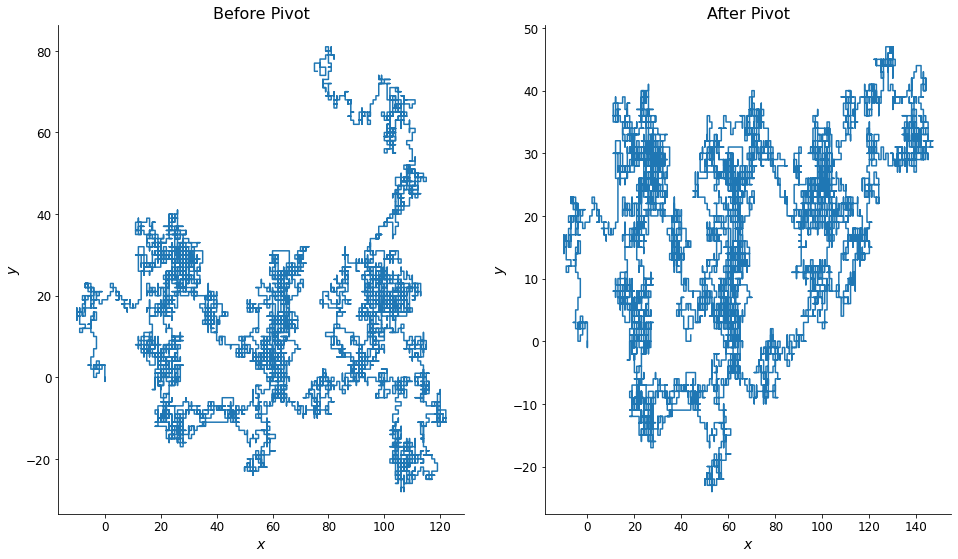

In [23]:
 """Test"""
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
RW_2=get_traj2(10**4)
ax1.plot(RW_2[:,0], RW_2[:,1])
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$y$")
ax1.set_title(r"Before Pivot");
RW2_2=pivot_traj(RW_2)
ax2.plot(RW2_2[:,0], RW2_2[:,1])
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")
ax2.set_title(r"After Pivot");

### Exercise 3.10
Write a function that counts the number of self-intersections of a RW. Notice that SAWs have 0 self intersections, so that will solve step 3 of the pivot algorithm, but will also be useful to generate the initial condition. One way of approaching this exercise is to count how many *different* points the path visits.

In [24]:
def count_self_intersections(traj2):
    """Count the number of self-intersections of a RW"""
    new_points_a = np.unique(traj2, axis=0) #count how many different, i.e. unique, points the path visits
    num_self_intersections = len(traj2) - len(new_points_a) #intersections = (length of the path) - (number of unique points)
    return num_self_intersections

### Exercise 3.11
Verify that your `count_self_intersecitons` function works properly by using short trajectories for which you know the answer.

Test 1 - Self Intersection Measured:  1 ,                Expected:  1 ,                Difference:  0
Test 2 - Self Intersection Measured:  2 ,                Expected:  2 ,                Difference:  0
Test 3 - Self Intersection Measured:  3 ,                Expected:  3 ,                Difference:  0
Test 4 - Self Intersection Measured:  2 ,                Expected:  4 ,                Difference:  0
Test 5 - Self Intersection Measured:  1 ,                Expected:  3 ,                Difference:  0
Test 6 - Self Intersection Measured:  2 ,                Expected:  2 ,                Difference:  0


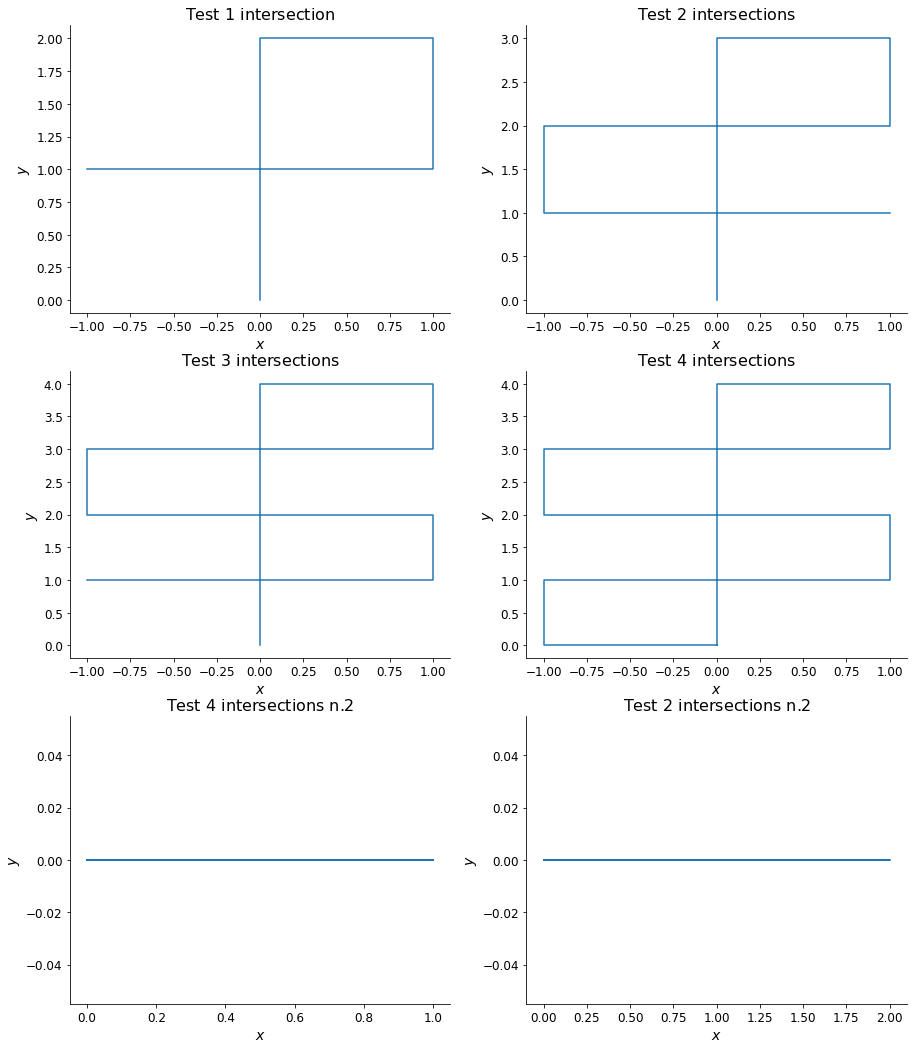

In [25]:
# your verifications here
length_test0=5
length_test00=5
length_test1=7
length_test2=11
length_test3=15
length_test4=17

RW_test0=np.zeros((length_test0,2))
RW_test00=np.zeros((length_test00,2))
RW_test1=np.zeros((length_test1,2))
RW_test2=np.zeros((length_test2,2))
RW_test3=np.zeros((length_test3,2))
RW_test4=np.zeros((length_test4,2))

RW_test0[0]=[0, 0]
RW_test0[1]=[1, 0]
RW_test0[2]=[0, 0]
RW_test0[3]=[1, 0]
RW_test0[4]=[0, 0]

RW_test00[0]=[0, 0]
RW_test00[1]=[1, 0]
RW_test00[2]=[2, 0]
RW_test00[3]=[1, 0]
RW_test00[4]=[0, 0]
 
RW_test1[0]=[0, 0]
RW_test1[1]=[0, 1]
RW_test1[2]=[0, 2]
RW_test1[3]=[1, 2]
RW_test1[4]=[1, 1]
RW_test1[5]=[0, 1]
RW_test1[6]=[-1, 1]

RW_test2[0]=[0, 0]
RW_test2[1]=[0, 1]
RW_test2[2]=[0, 2]
RW_test2[3]=[0, 3]
RW_test2[4]=[1, 3]
RW_test2[5]=[1, 2]
RW_test2[6]=[0, 2]
RW_test2[7]=[-1, 2]
RW_test2[8]=[-1, 1]
RW_test2[9]=[0, 1]
RW_test2[10]=[1, 1]

RW_test3[0]=[0, 0]
RW_test3[1]=[0, 1]
RW_test3[2]=[0, 2]
RW_test3[3]=[0, 3]
RW_test3[4]=[0, 4]
RW_test3[5]=[1, 4]
RW_test3[6]=[1, 3]
RW_test3[7]=[0, 3]
RW_test3[8]=[-1, 3]
RW_test3[9]=[-1, 2]
RW_test3[10]=[0, 2]
RW_test3[11]=[1, 2]
RW_test3[12]=[1, 1]
RW_test3[13]=[0, 1]
RW_test3[14]=[-1, 1]

RW_test4[0]=[0, 0]
RW_test4[1]=[0, 1]
RW_test4[2]=[0, 2]
RW_test4[3]=[0, 3]
RW_test4[4]=[0, 4]
RW_test4[5]=[1, 4]
RW_test4[6]=[1, 3]
RW_test4[7]=[0, 3]
RW_test4[8]=[-1, 3]
RW_test4[9]=[-1, 2]
RW_test4[10]=[0, 2]
RW_test4[11]=[1, 2]
RW_test4[12]=[1, 1]
RW_test4[13]=[0, 1]
RW_test4[14]=[-1, 1]
RW_test4[15]=[-1, 0]
RW_test4[16]=[0, 0]

fig, ((axtest1, axtest2), (axtest3, axtest4), (axtest0, axtest00)) = plt.subplots(3, 2, figsize=(15, 18))
axtest1.plot(RW_test1[:,0], RW_test1[:,1])
axtest1.set_xlabel(r"$x$")
axtest1.set_ylabel(r"$y$")
axtest1.set_title(r"Test" " " r"$1$" " " r"intersection");
axtest2.plot(RW_test2[:,0], RW_test2[:,1])
axtest2.set_xlabel(r"$x$")
axtest2.set_ylabel(r"$y$")
axtest2.set_title(r"Test" " " r"$2$" " " r"intersections");
axtest3.plot(RW_test3[:,0], RW_test3[:,1])
axtest3.set_xlabel(r"$x$")
axtest3.set_ylabel(r"$y$")
axtest3.set_title(r"Test" " " r"$3$" " " r"intersections")
axtest4.plot(RW_test4[:,0], RW_test4[:,1])
axtest4.set_xlabel(r"$x$")
axtest4.set_ylabel(r"$y$")
axtest4.set_title(r"Test" " " r"$4$" " " r"intersections");
axtest0.plot(RW_test0[:,0], RW_test0[:,1])
axtest0.set_xlabel(r"$x$")
axtest0.set_ylabel(r"$y$")
axtest0.set_title(r"Test" " " r"$4$" " " r"intersections n.2");
axtest00.plot(RW_test00[:,0], RW_test00[:,1])
axtest00.set_xlabel(r"$x$")
axtest00.set_ylabel(r"$y$")
axtest00.set_title(r"Test" " " r"$2$" " " r"intersections n.2");

self_intersections_test1=count_self_intersections(RW_test1)
self_intersections_test2=count_self_intersections(RW_test2)
self_intersections_test3=count_self_intersections(RW_test3)
self_intersections_test4=count_self_intersections(RW_test4)
self_intersections_test3=count_self_intersections(RW_test0)
self_intersections_test4=count_self_intersections(RW_test00)

x = [r"Test 1 - Self Intersection Measured: ", self_intersections_test1, ", " r"               Expected: ", 1,", " r"               Difference: ",count_self_intersections(RW_test1)-1]
y = [r"Test 2 - Self Intersection Measured: ", self_intersections_test2, ", " r"               Expected: ", 2,", " r"               Difference: ",count_self_intersections(RW_test2)-2]
z = [r"Test 3 - Self Intersection Measured: ", self_intersections_test3, ", " r"               Expected: ", 3,", " r"               Difference: ",count_self_intersections(RW_test3)-3]
w = [r"Test 4 - Self Intersection Measured: ", self_intersections_test4, ", " r"               Expected: ", 4,", " r"               Difference: " ,count_self_intersections(RW_test4)-4]
a = [r"Test 5 - Self Intersection Measured: ", self_intersections_test1, ", " r"               Expected: ", 3,", " r"               Difference: ",count_self_intersections(RW_test0)-3]
b = [r"Test 6 - Self Intersection Measured: ", self_intersections_test2, ", " r"               Expected: ", 2,", " r"               Difference: ",count_self_intersections(RW_test00)-2]
print(*x)
print(*y)
print(*z)
print(*w)
print(*a)
print(*b)

## Generating the initial condition
You might have noticed that the pivot algorithm requires an element of SAW($n$) as starting condition, to then generate a Markov chain easily. But how do you get this first element? We will use the following strategy:
1. Generate a standard 2D random walk, and count the number of self intersections.
2. Apply the pivot transformation to get a new 2D random walk, and count the number of self-intersections-
3. If the number of self-intersections has decreased or not changed, keep the new path. Else, keep the old one.
4. Go to 2, till the number of self-intersections is 0.

### Exercise 3.12
Write a function `get_first_SAW` that generates a SAW of given length

In [26]:
def get_first_SAW(lengthSAW, max_tries=1000000):
    trajSAW=get_traj2(lengthSAW)
    for i in range (max_tries):
        #If the path does not self-intersect than we have finished, so break the cycle.
        if (count_self_intersections(trajSAW) < 1):
            break
        else:
            trajSAW2=pivot_traj(trajSAW)
            # If the number of self-intersections has decreased or not changed, keep the new path. Else, keep the old one.
            if(count_self_intersections(trajSAW2)<=count_self_intersections(trajSAW)):
                trajSAW = trajSAW2
            # Error in case of max tries
            if(i == max_tries):
                print(r"ERROR MAX TRIES")
    return trajSAW

### Exercise 3.13
Generate and plot some 2D SAWs of different lengths. Be carefull, raise the length slowly! You can measure how long a cell takes executing using the `%%time` magic at the top of a cell.

CPU times: user 441 ms, sys: 25.5 ms, total: 466 ms
Wall time: 447 ms


Text(0.5, 1.0, 'Length: 100')

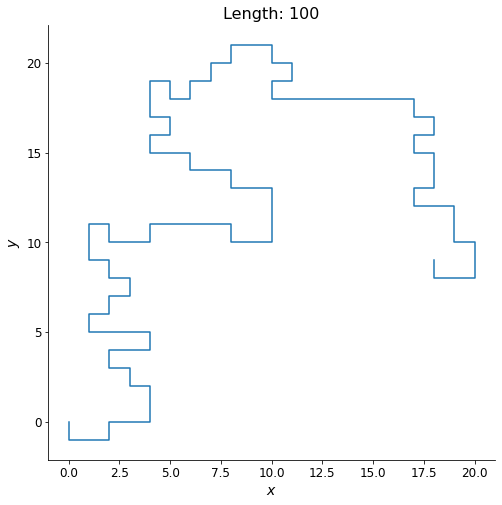

In [27]:
%%time
# your answer here
# use more than one cell!
length_SAW1=100

RW_SAW1=get_first_SAW(length_SAW1)
#plot
fig, (axSAW1) = plt.subplots(1, 1, figsize=(8, 8))
axSAW1.plot(RW_SAW1[:,0], RW_SAW1[:,1])
axSAW1.set_xlabel(r"$x$")
axSAW1.set_ylabel(r"$y$")
axSAW1.set_title(r"Length: " + str(length_SAW1));

CPU times: user 32 s, sys: 38 ms, total: 32 s
Wall time: 32.1 s


Text(0.5, 1.0, 'Length: 1000')

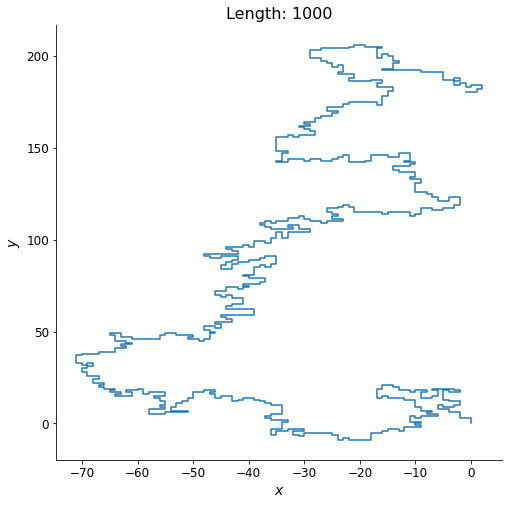

In [28]:
%%time

length_SAW2=1000

RW_SAW2=get_first_SAW(length_SAW2)
#plot
fig, (axSAW2) = plt.subplots(1, 1, figsize=(8, 8))
axSAW2.plot(RW_SAW2[:,0], RW_SAW2[:,1])
axSAW2.set_xlabel(r"$x$")
axSAW2.set_ylabel(r"$y$")
axSAW2.set_title(r"Length: " + str(length_SAW2));

CPU times: user 20min 50s, sys: 2.21 s, total: 20min 53s
Wall time: 20min 54s


Text(0.5, 1.0, 'Length: 5000')

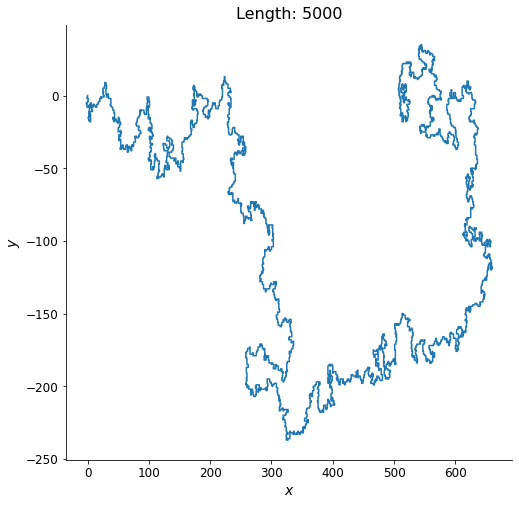

In [29]:
%%time

length_SAW3=5000

RW_SAW3=get_first_SAW(length_SAW3)
#plot
fig, (axSAW3) = plt.subplots(1, 1, figsize=(8, 8))
axSAW3.plot(RW_SAW3[:,0], RW_SAW3[:,1])
axSAW3.set_xlabel(r"$x$")
axSAW3.set_ylabel(r"$y$")
axSAW3.set_title(r"Length: " + str(length_SAW3));

CPU times: user 10h 48min 43s, sys: 6min 33s, total: 10h 55min 17s
Wall time: 2h 49min 57s


Text(0.5, 1.0, 'Length: 10000')

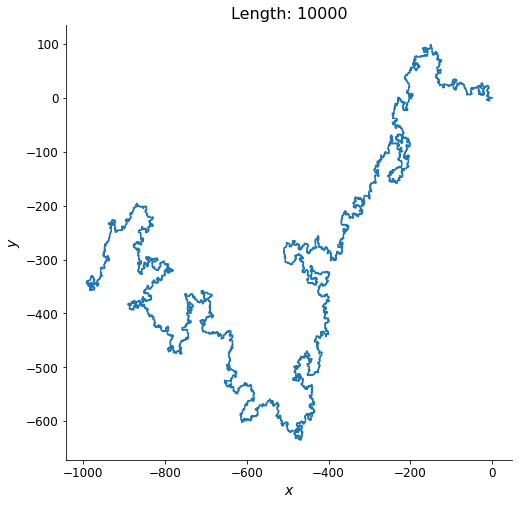

In [30]:
%%time

length_SAW4=10000

RW_SAW4=get_first_SAW(length_SAW4)
#plot
fig, (axSAW4) = plt.subplots(1, 1, figsize=(8, 8))
axSAW4.plot(RW_SAW4[:,0], RW_SAW4[:,1])
axSAW4.set_xlabel(r"$x$")
axSAW4.set_ylabel(r"$y$")
axSAW4.set_title(r"Length: " + str(length_SAW4));

## Exercise 3.14
Write a function `get_next_SAW` that, given a SAW, generates another SAW using the pivot algorithm. Your function should check that the input RW is really a SAW. Remember the steps:

1. Apply the pivot transformation
2. Check if the new path is self-avoiding. **If so, return it. Otherwise, return the original path.**

In [31]:
def get_next_SAW(trajSAW):
    # make sure input traj is SAW
    assert count_self_intersections(trajSAW) == 0
    
    # pivot step
    proposed_traj = pivot_traj(trajSAW)
    
    # count intersections
    num_intersections = count_self_intersections(proposed_traj)
    
    # if it's a SAW return it
    if (num_intersections == 0):
        return(proposed_traj)
    
    # if not return the orinal path
    else:
        return(trajSAW)

### Mean Squared Displacement in SAW
A quantity of interest in RWs is the mean squared displacement, which is simply the (squared) distance between the endpoints of the walk. Usually, one writes

$$
\left\langle X(n)^2 \right\rangle \sim n^{2 \nu}
$$

As you know, for a standard RW of $n$ steps, the mean-squared displacement scales like $n$, so $\nu=1/2$. However, the exponent for SAW is **different**! Althought it has not been formally proven (still), it is believed that the exponent for SAW is $\nu=3/4$. That is, for a self-avoiding random walk, the mean squared displacement scales as $n^{3/2}$.

### Exercise 3.15
Explain why it makes sense that the mean-squared displacement exponent of SAW is **greater** than that of standard RW. 

*Your answer here! (cannot be empty...)*

#### Answer

A first explaination is that each step of standard RW have a $2^{-d}$ (with $d$ the dimension) probability of undoing the last move, while for definition a SAW can't do it, so it's natural that a SAW will be, with a direct proportionality to the number of steps, statistically farther away from the origin than a standard SAW.

Moreover for a 2 dimensional RW each step has 4 possibilities, while for a 2D SAW only the first step has 4 possibilities, then the second, the third and the fourth all have 3 possibilities, and the subsequents steps have at best 3 possibilities, this tends the path to not close on itself and so to step away from the starting point more easily.

### Exercise 3.16
Verify numerically the scaling of the mean-squared displacement of SAW. Notice that you don't need to store all the SAWs, just the endpoints. You could follow this scheme:

1. Generate a first SAW with your `get_first_SAW()` function
2. Generate the next SAW using your `get_next_SAW()` function, and store the endpoint.
3. Iterate step 2 for as many steps as required
4. Compute the average mean-squared displacement of the stored endpoints

Then repeating steps 1-4 for different lengths, and plot the results in double-logarithmic axis. Compare your results with the theoretical exponent. Do they agree?

CPU times: user 3h 50min 53s, sys: 20.8 s, total: 3h 51min 14s
Wall time: 3h 51min 22s


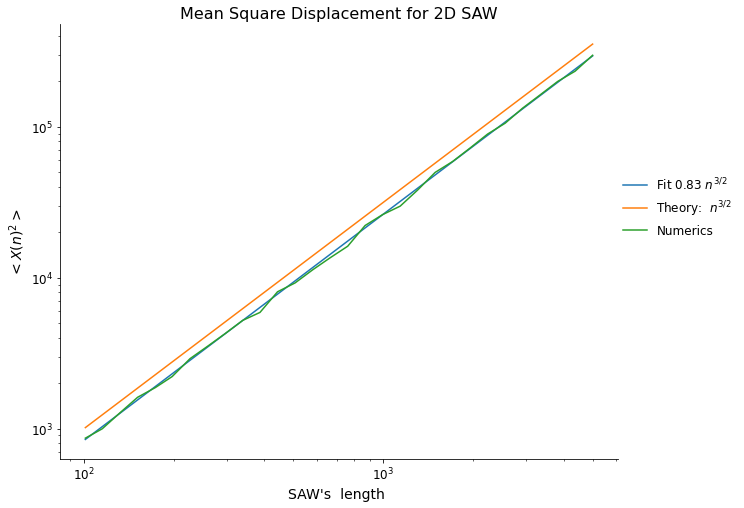

In [32]:
%%time
#range of length to compute
length_SAW_min=101
length_SAW_max=5001
num=30 #number of lengths in the range to compute
length_array_SAW = np.array([
    int(x)
    for x in np.geomspace(length_SAW_min, length_SAW_max, num=num)
])

data=5000 #number of SAWs to average for each length
data_array=np.zeros(num) #array to store the endpoint displacement
n=0 #this is needed to use the same "for" cycle both to select the length and to move the data_array index
max_tries=1000000 #set a number of max tries for the generation of the next SAW
flag=-1 #this is a flag to check if the generated SAW is different from the previous



for length_SAW in length_array_SAW: #select the length 
    
    # generate a first SAW of the selected length
    RW_SAW_first=get_first_SAW(length_SAW)
    
    for k in range (0, data): #repeat "data" times to get the average
        
        for i in range(0, max_tries): #Break if too many tries
            
            RW_SAW_next=get_next_SAW(RW_SAW_first)
            for j in range(1, length_SAW): #check if the new SAW is different from the "seed-path", we start from 1 because all paths start from the origin
                #set the flag equal to 1 if the new path is different
                if np.array_equiv(RW_SAW_first[j],RW_SAW_next[j]):
                    flag=0
                    continue
                else:
                    flag=1
                    break
            if(flag==1): #if the path is different then store the endpoint
                RW_SAW_first=RW_SAW_next
                data_array[n]=data_array[n]+pow(RW_SAW_first[-1,1],2)+pow(RW_SAW_first[-1,1],2) #store the endpoint displacement
                break
                
    data_array[n]=data_array[n]/data #average the endpoints displacement of this length
    n+=1 #move to the next length
    
    
    
#Fit
fSAW = lambda length_array_SAW, kSAW: kSAW * pow(length_array_SAW,3/2) # 3/2 power fit
popt, _ = curve_fit(fSAW, length_array_SAW, data_array)
kSAW = popt[0]
ktruncSAW = "%.2f" % kSAW

#Plot
fig, (ax_SAW) = plt.subplots(1, 1, figsize=(10, 8))
ax_SAW.loglog(length_array_SAW, kSAW * pow(length_array_SAW,3/2), label=r"Fit " + str(ktruncSAW) + r" $n^{3/2}$")
ax_SAW.loglog(length_array_SAW, pow(length_array_SAW,3/2), label=r"Theory:  $n^{3/2}$")
ax_SAW.loglog(length_array_SAW, data_array, label="Numerics")
ax_SAW.set_xlabel(r"SAW's " " length ")
ax_SAW.set_ylabel(r"$<X(n)^2>$")
ax_SAW.set_title(r"Mean Square Displacement for 2D SAW");
ax_SAW.legend(loc=(1, 0.5), frameon=False);

#### Conclusions
The simulation of the mean-squared displacement, for a SAW in 2 dimensions, as a function of the SAW length $n$, is compatible with a $n^{3/2}$ scaling, i.e. it is compatible with the theoretical exponent!

In [48]:
md("More precisely it is compatible with a {} * n^(3/2) scaling.".format(ktruncSAW))

More precisely it is compatible with a 0.83 * n^(3/2) scaling.

# 